In [ ]:
import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.append("..")

import os
#os.environ['CUDA_VISIBLE_DEVICES']='2'
os.environ['D4RL_SUPPRESS_IMPORT_ERROR'] = '1'

import gym
import d4rl

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

from matplotlib.colors import LinearSegmentedColormap, ListedColormap
from matplotlib import patches
from subgoals import SUBGOALS
SUBGOALS = SUBGOALS['small']

import equinox as eqx
import jax
import jax.numpy as jnp
import functools

In [ ]:
@eqx.filter_vmap(in_axes=dict(ensemble=eqx.if_array(0), s=None))
def eval_ensemble_psi(ensemble, s):
    return ensemble.psi_net(s)

@eqx.filter_vmap(in_axes=dict(ensemble=eqx.if_array(0), s=None, g=None, z=None))
def eval_ensemble_icvf_viz(ensemble, s, g, z):
    return eqx.filter_vmap(ensemble.classic_icvf_initial)(s, g, z)

@eqx.filter_jit
def get_gcvalue(agent, s, g, z):
    v_sgz_1, v_sgz_2 = eval_ensemble_icvf_viz(agent.value_learner.model, s, g, z)
    return (v_sgz_1 + v_sgz_2) / 2

def get_v_gz(agent, initial_state, target_goal, observations):
    initial_state = jnp.tile(initial_state, (observations.shape[0], 1))
    target_goal = jnp.tile(target_goal, (observations.shape[0], 1))
    return -1 * get_gcvalue(agent, initial_state, observations, target_goal)
    
def get_v_zz(agent, goal, observations):
    goal = jnp.tile(goal, (observations.shape[0], 1))
    return get_gcvalue(agent, observations, goal, goal)

@eqx.filter_vmap(in_axes=dict(agent=None, obs=None, goal=0))
def get_v_zz_heatmap(agent, obs, goal): # goal - whole traj
    goal = jnp.tile(goal, (obs.shape[0], 1))
    return get_gcvalue(agent, obs, goal, goal)

In [ ]:
def generate_maze_img(ax, fig, n=50, icvf_values="not", state_list=None):
    torso_x, torso_y = env.env.env._wrapped_env._init_torso_x, env.env.env._wrapped_env._init_torso_y
    S =  env.env.env._wrapped_env._maze_size_scaling
    points = XY(env, n=n)
    # x = np.round(points[:, 0]).reshape(100, 100)
    # y = np.round(points[:, 1]).reshape(100, 100)
    whole_grid = state_list[-20] #d4rl_ds['observations'][-1]
    whole_grid = np.tile(whole_grid, (points.shape[0], 1))
    whole_grid[:, :2] = points
    
    if icvf_values is None:
        Z = np.random.rand(n, n)
    else:
        Z = (get_v_zz_heatmap(icvf_model, whole_grid, state_list) + 10)#.mean(0)
        indx = np.argpartition(Z, -4)[..., :-4]
        Z[:, indx] = 0
        Z = Z.mean(0)
    im = ax.pcolormesh(points[:,0].reshape(n, n), points[:, 1].reshape(n, n), Z.reshape(n, n), edgecolor='black', shading='nearest')
    
    for i in range(len(env.env.env._wrapped_env._maze_map)):
        for j in range(len(env.env.env._wrapped_env._maze_map[0])):
            struct = env.env.env._wrapped_env._maze_map[i][j]
            if struct == 1:
                rect = patches.Rectangle((j *S - torso_x - S/ 2,
                                        i * S- torso_y - S/ 2),
                                        S,
                                        S, linewidth=1, facecolor='RosyBrown', alpha=1.0)
                ax.add_patch(rect)
    ax.set_xlim(0 - S /2 + 0.6 * S - torso_x, len(env.env.env._wrapped_env._maze_map[0]) * S - torso_x - S/2 - S * 0.6)
    ax.set_ylim(0 - S/2 + 0.6 * S - torso_y, len(env.env.env._wrapped_env._maze_map) * S - torso_y - S/2 - S * 0.6)
    fig.colorbar(im)
    return ax

def get_starting_boundary(env):
    torso_x, torso_y = env.env.env._wrapped_env._init_torso_x, env.env.env._wrapped_env._init_torso_y
    maze_map = env.env.env._wrapped_env._maze_map
    S = env.env.env._wrapped_env._maze_size_scaling
    return (0 - S / 2 + S - torso_x, 0 - S/2 + S - torso_y), (len(maze_map[0]) * S - torso_x - S/2 - S, len(maze_map) * S - torso_y - S/2 - S)

def XY(env, n=10):
    bl, tr = get_starting_boundary(env)
    X = np.linspace(bl[0] + 0.04 * (tr[0] - bl[0]) , tr[0] - 0.04 * (tr[0] - bl[0]), n)
    Y = np.linspace(bl[1] + 0.04 * (tr[1] - bl[1]) , tr[1] - 0.04 * (tr[1] - bl[1]), n)
    
    X,Y = np.meshgrid(X,Y)
    states = np.array([X.flatten(), Y.flatten()]).T
    return states

## ICVF pretrained on Antmaze-umaze-diverse-v2

In [ ]:
env = gym.make("antmaze-umaze-v2")
d4rl_ds = d4rl.qlearning_dataset(env)
dones_float = np.zeros_like(d4rl_ds['rewards'])

for i in range(len(dones_float) - 1):
    if np.linalg.norm(d4rl_ds['observations'][i + 1] - d4rl_ds['next_observations'][i]) > 1e-6 or d4rl_ds['terminals'][i] == 1.0:
        dones_float[i] = 1
    else:
        dones_float[i] = 0
dones_float[-1] = 1
d4rl_ds['dones_float'] = dones_float

In [ ]:
from src.agents import icvf
from main import get_traj_v_icvf
icvf_model = icvf.create_eqx_learner(seed=42,
                                     observations=d4rl_ds['observations'][0],
                                     hidden_dims=[256, 256],
                                     load_pretrained_icvf=True)


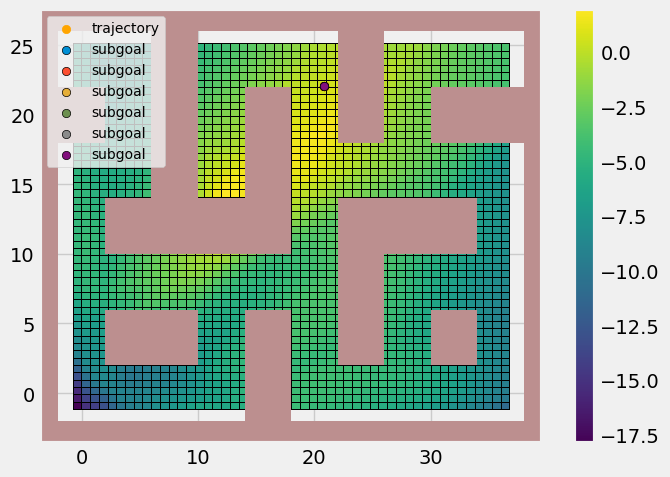

In [61]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(7, 5))
state_list = d4rl_ds['observations'][np.arange(start=3500, stop=3630)]
SUBGOALS = state_list[[0, 25, 50, 85, 100, 129]]
generate_maze_img(ax, fig, state_list=state_list)

plt.scatter(state_list[:, 0], state_list[:, 1], alpha=1, label='trajectory', color='orange')
for i in range(SUBGOALS.shape[0]):
    plt.scatter(*SUBGOALS[i, :2], label="subgoal", edgecolors='black', alpha=1)
    
plt.legend(loc='upper left', fontsize=10)
fig.tight_layout()


In [ ]:
env = gym.make("antmaze-large-diverse-v2")
d4rl_ds = d4rl.qlearning_dataset(env)
dones_float = np.zeros_like(d4rl_ds['rewards'])
for i in range(len(dones_float) - 1):
    if np.linalg.norm(d4rl_ds['observations'][i + 1] - d4rl_ds['next_observations'][i]) > 1e-6 or d4rl_ds['terminals'][i] == 1.0:
        dones_float[i] = 1
    else:
        dones_float[i] = 0
dones_float[-1] = 1
d4rl_ds['dones_float'] = dones_float

In [ ]:
fig, ax = plt.subplots(figsize=(7, 5))
generate_maze_img(ax, fig, icvf_values=None)

state_list = d4rl_ds['observations'][np.arange(start=10000, stop=10500)]
SUBGOALS = state_list[[0, 30, 50, 80, 115, 145, 190, 220, 260, 299]]
plt.scatter(state_list[:, 0], state_list[:, 1], alpha=1, label='trajectory', color='orange')
for i in range(SUBGOALS.shape[0]):
    plt.scatter(*SUBGOALS[i, :2], label="subgoal", edgecolors='black', alpha=1)
    
plt.legend(loc='upper left', fontsize=10)
fig.tight_layout()


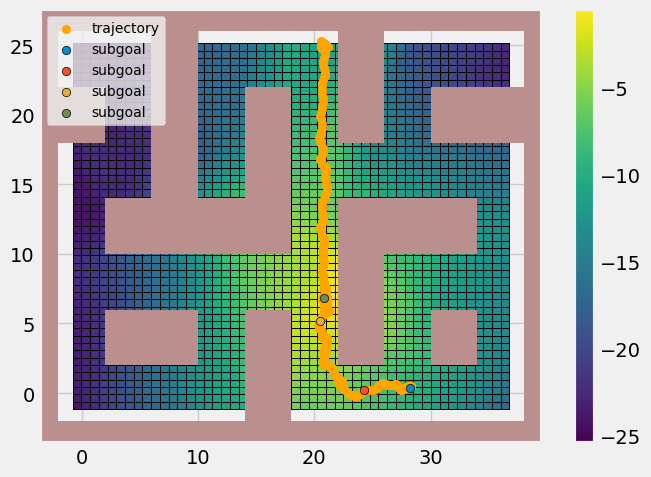

In [100]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(7, 5))

state_list = d4rl_ds['observations'][np.arange(start=43000, stop=43350)] #(start=10000, stop=10190)
generate_maze_img(ax, fig, state_list=state_list)

SUBGOALS = state_list[[0, 30, 120, 189]]
plt.scatter(state_list[:, 0], state_list[:, 1], alpha=1, label='trajectory', color='orange')
for i in range(SUBGOALS.shape[0]):
    plt.scatter(*SUBGOALS[i, :2], label="subgoal", edgecolors='black', alpha=1)
    
plt.legend(loc='upper left', fontsize=10)
fig.tight_layout()


In [13]:
#### import equinox as eqx
import jax.numpy as jnp

@eqx.filter_vmap(in_axes=dict(ensemble=eqx.if_array(0), s=None, g=None, z=None))
def eval_ensemble_icvf_viz(ensemble, s, g, z):
    return eqx.filter_vmap(ensemble.classic_icvf_initial)(s, g, z)

In [58]:
state_list = d4rl_ds['observations'][np.arange(start=10000, stop=10190)]
SUBGOALS = state_list[[0, 30, 120, 189]]
base_observation = jnp.tile(SUBGOALS[-1, :], (state_list.shape[0], 1))
eval_ensemble_icvf_viz(icvf_model.value_learner.model, state_list, base_observation, base_observation).mean(0)

Array([-17.062653  , -17.655804  , -17.879055  , -17.704906  ,
       -16.963924  , -16.891373  , -17.211407  , -16.328213  ,
       -15.968935  , -15.952837  , -16.050034  , -16.035576  ,
       -15.136642  , -14.415972  , -14.680345  , -14.762591  ,
       -14.581438  , -14.352939  , -13.727652  , -13.691419  ,
       -13.639204  , -13.360559  , -14.043884  , -14.223169  ,
       -13.677648  , -13.477322  , -13.073084  , -12.192192  ,
       -11.79924   , -12.051615  , -12.817753  , -14.2389965 ,
       -13.710707  , -12.834246  , -14.098736  , -14.410706  ,
       -14.602623  , -14.936066  , -14.290462  , -14.090942  ,
       -13.831221  , -13.996035  , -13.928986  , -13.753057  ,
       -12.883813  , -12.896423  , -12.43659   , -11.866659  ,
       -11.604763  , -12.287632  , -12.729628  , -12.517317  ,
       -12.489918  , -12.104954  , -12.258008  , -11.8547125 ,
       -11.948196  , -12.05852   , -11.9240055 , -11.737858  ,
       -10.961405  , -11.28039   , -11.045387  , -11.21

In [45]:
for sg in SUBGOALS:
    sg_repr = np.linalg.norm(eval_ensemble_psi(icvf_model.value_learner.model, sg) - eval_ensemble_psi(icvf_model.value_learner.model, SUBGOALS[-1]))
    sg_value = get_v_zz(icvf_model, sg[None], SUBGOALS[-1, :][None])
    print(f"Value: {sg_value}", f"Norm: {sg_repr}")

Value: [-24.707027] Norm: 13.598323822021484
Value: [-19.412914] Norm: 14.645350456237793
Value: [-12.7963915] Norm: 13.397102355957031
Value: [-0.03296447] Norm: 0.0


[0, 11, 13, 14, 18, 19, 77, 179]


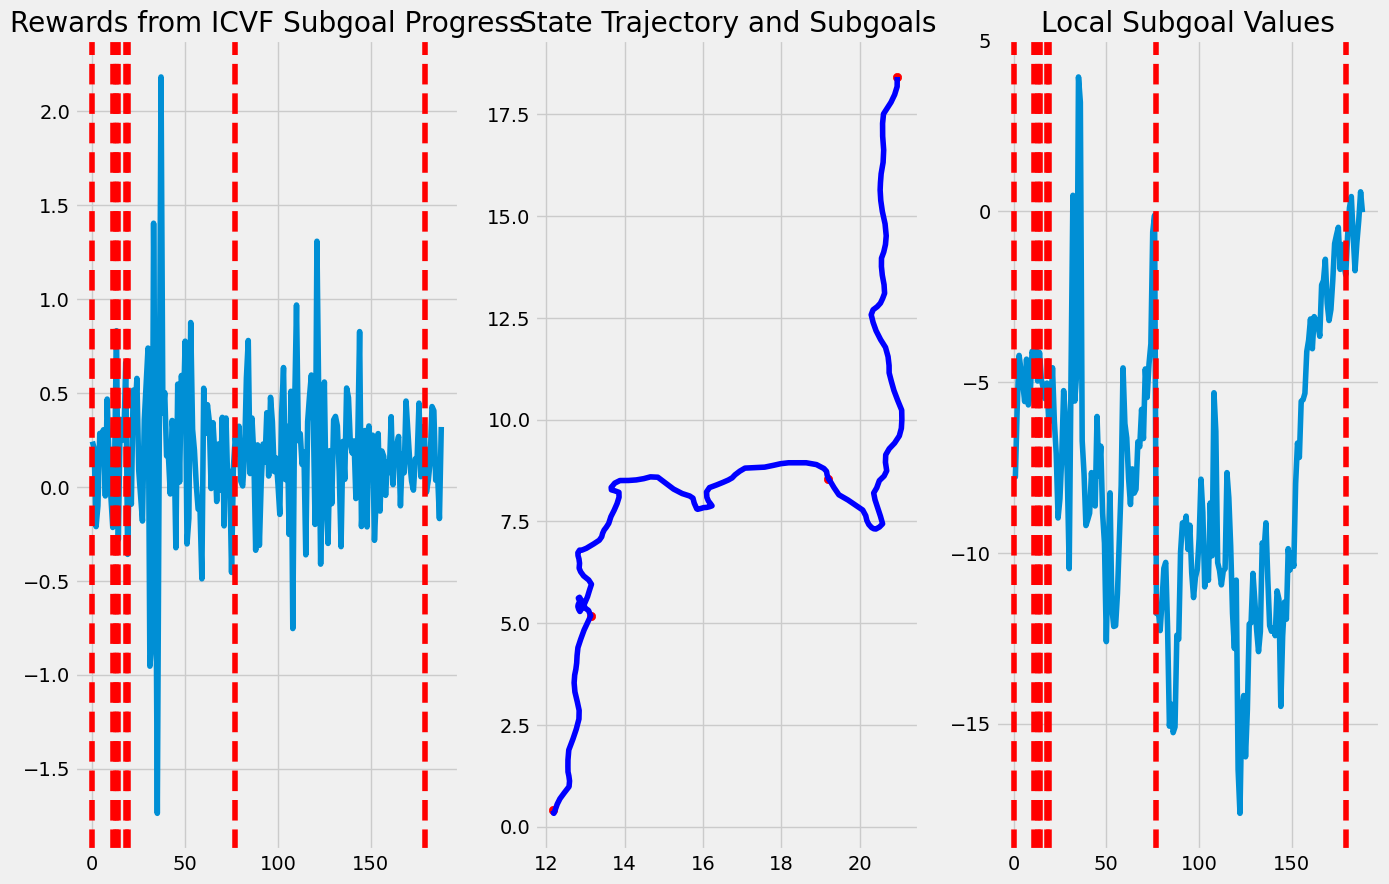

In [46]:
rews = []
idx = 1
sg = SUBGOALS[idx]
eps = 0.5
subgoal_switches = []
vals = []

for i, state in enumerate(state_list[1:]):
    reward = 0
    old_idx = idx
    idx = np.argmax([get_v_zz(icvf_model, state[None], sg[None]) for sg in SUBGOALS])
    if old_idx != idx:
        subgoal_switches.append(i)
    sg = SUBGOALS[min(idx + 1, len(SUBGOALS) - 1)] # set next subgoal candidate
    
    if get_v_zz(icvf_model, state[None], sg[None]) <= eps:
        reward += 0.2

    val_to_sg = get_v_zz(icvf_model, state[None], sg[None]) # negative value
    vals.append(val_to_sg)
    last_val_to_sg = get_v_zz(icvf_model, state_list[i][None], sg[None]) # negative value
    val_diff = np.array(val_to_sg - last_val_to_sg).item()
    reward -= 0.2 * val_diff
    rews.append(reward)

print(subgoal_switches)
fig, axs = plt.subplots(1, 3, figsize=(15, 10))
axs[0].set_title('Rewards from ICVF Subgoal Progress')
axs[1].set_title('State Trajectory and Subgoals')
axs[2].set_title('Local Subgoal Values')
axs[0].plot(rews)

for i in subgoal_switches:
    axs[0].axvline(x=i, color='r', linestyle='--')
    
axs[1].plot(state_list[:, 0], state_list[:, 1], color='b')
axs[1].scatter(SUBGOALS[:, 0], SUBGOALS[:, 1], color='r')
axs[2].plot(vals)
for i in subgoal_switches:
    axs[2].axvline(x=i, color='r', linestyle='--')


In [18]:
# loop through state list from beginning to end. 
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
START_IDX = 50
state_indxs = []
avds  = []
for i, state in enumerate(state_list):
    state_indxs.append(i)
    avds.append(-1 * get_v_zz(icvf_model, state[None], SUBGOALS[-1][None]) +  get_v_zz(icvf_model, state_list[START_IDX][None], SUBGOALS[-1][None]))

scale_adv = (np.array(avds) - avds[START_IDX]) / (avds[-1] - avds[START_IDX] + 1e-8)

axs[0].plot(state_indxs, avds)
axs[0].set_title('Advantage Across Expert Trajectory')
axs[0].set_ylabel('ICVF(s, g, g) - ICVF(s_0, g, g)')
axs[0].set_xlabel('s index')
axs[0].axvline(x=START_IDX, color='r', linestyle='--')

values  = []
for i, state in enumerate(state_list):
    values.append(-1 * get_v_zz(icvf_model, state_list[START_IDX][None], state[None]))

scale_values = (np.array(values) - values[START_IDX]) / (values[-1] - values[START_IDX] + 1e-8)

axs[1].plot(state_indxs, values)
axs[1].set_title('Reachability of an Expert State from Start')
axs[1].set_ylabel('ICVF(s, s_i, s_i)')
axs[1].set_xlabel('s index')
axs[1].axvline(x=START_IDX, color='r', linestyle='--')

a, b = 1, 1

def h_test(adv, val):
    scale_values = (np.array(val) - values[START_IDX]) / (values[-1] - values[START_IDX] + 1e-8)
    # scale_adv = (np.array(adv) - np.min(avds)) / (np.max(avds) - np.min(avds) + 1e-8)
    scale_adv = (np.array(adv) - avds[START_IDX]) / (avds[-1] - avds[START_IDX] + 1e-8)
    return a*scale_adv * b*(1 - scale_values)

heuristic  = [(a * adv) + (b * val) for adv, val in zip(avds, values)]
# heuristic = [h_test(adv, val) for adv, val in zip(avds, values)]
axs[2].plot(state_indxs, heuristic)
axs[2].set_title('Heuristic Sum of Advantage and Reachability')
axs[2].set_ylabel('Sum')
axs[2].set_xlabel('s index')
axs[2].axvline(x=START_IDX, color='r', linestyle='--')
plt.savefig("test2.png", dpi=100)
plt.show()


In [28]:
import matplotlib.animation as animation 

from IPython.display import HTML

a, b = 1, 1.1
state_indxs = []
fig, ax = plt.subplots()
ax.set_title('Subgoal Planning on Expert Trajectory')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.plot(state_list[:, 0], state_list[:, 1], color='b')
scat = ax.scatter(state_list[0, 0], state_list[0, 1], color='r')
abc = None
def animate(i):
    global abc
    scat.set_offsets(state_list[i, :2])
    
    values  = []
    for j, state in enumerate(state_list):
        values.append(-1 * get_v_zz(icvf_model, state_list[i][None], state[None]))
    avds = []
    for j, state in enumerate(state_list):
        state_indxs.append(j)
        avds.append(-1 * get_v_zz(icvf_model, state[None], SUBGOALS[-1][None]) + get_v_zz(icvf_model, state_list[i][None], SUBGOALS[-1][None]))
    
    heuristic  = [a * adv + b * val for adv, val in zip(avds, values)]
    max_idx = np.argmax(heuristic)
    if abc is not None:
        abc.set_visible(False)
    abc = ax.scatter(state_list[max_idx, 0], state_list[max_idx, 1], color='g')
    return scat,

anim = animation.FuncAnimation(fig, animate, frames=len(state_list), interval=200, blit=True)


HTML(anim.to_html5_video())


[Array([-12.261929], dtype=float32), Array([-10.933132], dtype=float32), Array([-11.627936], dtype=float32), Array([-15.406983], dtype=float32), Array([-26.660723], dtype=float32), Array([-26.959492], dtype=float32), Array([-28.347834], dtype=float32), Array([-32.350677], dtype=float32), Array([-37.090324], dtype=float32), Array([-36.42006], dtype=float32), Array([-38.79787], dtype=float32), Array([-39.8505], dtype=float32), Array([-42.256523], dtype=float32), Array([-41.57753], dtype=float32), Array([-41.87641], dtype=float32), Array([-39.981743], dtype=float32), Array([-41.559708], dtype=float32), Array([-42.96714], dtype=float32), Array([-43.8748], dtype=float32), Array([-43.35325], dtype=float32), Array([-43.0171], dtype=float32), Array([-42.94397], dtype=float32), Array([-39.361183], dtype=float32), Array([-35.23635], dtype=float32), Array([-37.674843], dtype=float32), Array([-36.811405], dtype=float32), Array([-35.588875], dtype=float32), Array([-35.384514], dtype=float32), Array

CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '640x480', '-pix_fmt', 'rgba', '-r', '5.0', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', '/tmp/tmpxpyb3d6a/temp.m4v']' returned non-zero exit status 255.

In [27]:
get_v_zz(icvf_model, state_list[175][None], SUBGOALS[-1][None])

Array([-9.874206], dtype=float32)

In [9]:
@eqx.filter_jit
def get_traj_v_icvf(agent, observations):
    def get_v(s, g):
        return eval_ensemble_icvf_viz(agent.value_learner.model, s[None], g[None], g[None]).mean()
    
    all_values = jax.vmap(jax.vmap(get_v, in_axes=(None, 0)), in_axes=(0, None))(observations, observations)
    return {
        'dist_to_beginning': all_values[:, 0],
        'dist_to_end': all_values[:, -1],
        'dist_to_middle': all_values[:, all_values.shape[1] // 2]}
    
traj_metrics = get_traj_v_icvf(icvf_model, xy)

In [10]:
from src import viz_utils
viz_trajectory = viz_utils.make_visual_no_image(traj_metrics, 
            [
            functools.partial(viz_utils.visualize_metric, metric_name=k) for k in traj_metrics.keys()
                ]
        )
plt.savefig('viz_trajectory.png', dpi=100)

In [35]:
import functools
def get_starting_boundary():
        torso_x, torso_y = env.env.env._wrapped_env._init_torso_x, env.env.env._wrapped_env._init_torso_y
        S =  env.env.env._wrapped_env._maze_size_scaling
        return (0 - S / 2 + S - torso_x, 0 - S/2 + S - torso_y), (len(env.env.env._wrapped_env._maze_map[0]) * S - torso_x - S/2 - S, len(env.env.env._wrapped_env._maze_map) * S - torso_y - S/2 - S)

def draw(ax):
    torso_x, torso_y = env.env.env._wrapped_env._init_torso_x, env.env.env._wrapped_env._init_torso_y
    S =  env.env.env._wrapped_env._maze_size_scaling
    for i in range(len(env.env.env._wrapped_env._maze_map)):
        for j in range(len(env.env.env._wrapped_env._maze_map[0])):
            struct = env.env.env._wrapped_env._maze_map[i][j]
            if struct == 1:
                rect = patches.Rectangle((j *S - torso_x - S/ 2,
                                        i * S- torso_y - S/ 2),
                                        S,
                                        S, linewidth=1, facecolor='RosyBrown', alpha=1.0)
                ax.add_patch(rect)
    ax.set_xlim(0 - S /2 + 0.6 * S - torso_x, len(env.env.env._wrapped_env._maze_map[0]) * S - torso_x - S/2 - S * 0.6)
    ax.set_ylim(0 - S/2 + 0.6 * S - torso_y, len(env.env.env._wrapped_env._maze_map) * S - torso_y - S/2 - S * 0.6)
    
def plot_value(value_fn, N=20):
    def XY(n=20):
        bl, tr = get_starting_boundary()
        X = np.linspace(bl[0] + 0.04 * (tr[0] - bl[0]) , tr[0] - 0.04 * (tr[0] - bl[0]), n)
        Y = np.linspace(bl[1] + 0.04 * (tr[1] - bl[1]) , tr[1] - 0.04 * (tr[1] - bl[1]), n)
        
        X,Y = np.meshgrid(X,Y)
        states = np.array([X.flatten(), Y.flatten()]).T
        return states

    ax= plt.gca()
    observations = XY()
    base_observations = np.tile(d4rl_ds['observations'][0], (observations.shape[0], 1))
    base_observations[:, :2] = observations
    values = eqx.filter_vmap(value_fn, in_axes=(None, 0, None))(icvf_model, state_list, base_observations).mean(0)
    #values = get_v_gz(icvf_model, xy[0], base_observation[0], base_observations)
    x, y = observations[:, 0], observations[:, 1]
    x = x.reshape(N, N)
    y = y.reshape(N, N)
    values = values.reshape(N, N)
    mesh = ax.pcolormesh(x, y, values, cmap='viridis')
    draw(ax)

    plt.colorbar(mesh, orientation='vertical')
    plt.savefig('heatmap3.png', dpi=100)
    
plot_value(value_fn=get_v_zz)
plt.clf()
plt.close()

In [4]:
env = gym.make("antmaze-large-diverse-v2")
d4rl_ds = d4rl.qlearning_dataset(env)

Target Goal:  (32.97756252476421, 24.903303970009457)


load datafile: 100%|██████████████████████████████████████████████████████████████████████| 8/8 [00:02<00:00,  3.35it/s]


In [5]:
# https://github.com/Farama-Foundation/D4RL/blob/master/d4rl/locomotion/maze_env.py
#env.env.env._wrapped_env??

env.env.env._wrapped_env._maze_map

[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 'r', 0, 0, 0, 1, 0, 0, 0, 0, 0, 1],
 [1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1],
 [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1],
 [1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1],
 [1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1],
 [1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1],
 [1, 0, 0, 1, 0, 0, 0, 1, 0, 'g', 0, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]

In [6]:
for i in range(len(env.env.env._wrapped_env._maze_map)):
    for j in range(len(env.env.env._wrapped_env._maze_map[0])):
        if env.env.env._wrapped_env._maze_map[i][j] in ['r', 'g']:
            env.env.env._wrapped_env._maze_map[i][j] = 0

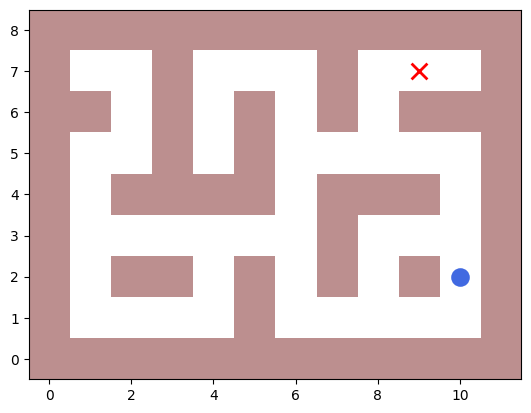

In [7]:
import numpy as np
plt.imshow(1 - np.array(env.env.env._wrapped_env._maze_map), cmap=cmap, origin="lower")
plt.scatter(*env.env.env._wrapped_env._xy_to_rowcol((33.12297854530087, 24.974616400316876))[::-1], marker="x", c='red', s=130, linewidths=2)
plt.scatter(*env.env.env._wrapped_env._xy_to_rowcol((36.376736 ,  5.238806))[::-1], marker="o", c='royalblue', s=130, linewidths=2)

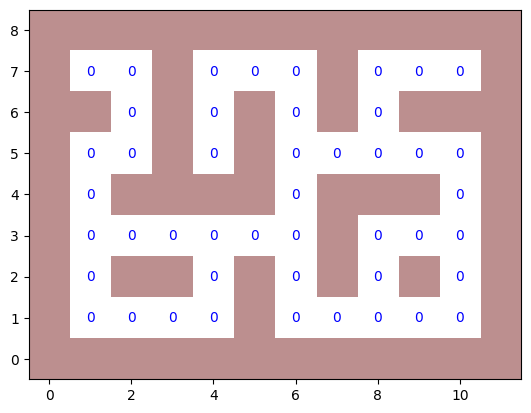

In [8]:
plt.imshow(1 - np.array(env.env.env._wrapped_env._maze_map), cmap=cmap, origin="lower")
for i in range(len(env.env.env._wrapped_env._maze_map)):
    for j in range(len(env.env.env._wrapped_env._maze_map[0])):
        if np.array(env.env.env._wrapped_env._maze_map)[i, j] != 1:
            text = plt.text(j, i, np.array(env.env.env._wrapped_env._maze_map)[i, j],
                           ha="center", va="center", color="b")

In [44]:
xy = d4rl_ds['observations'][np.arange(2000, 2050)][:, :2]

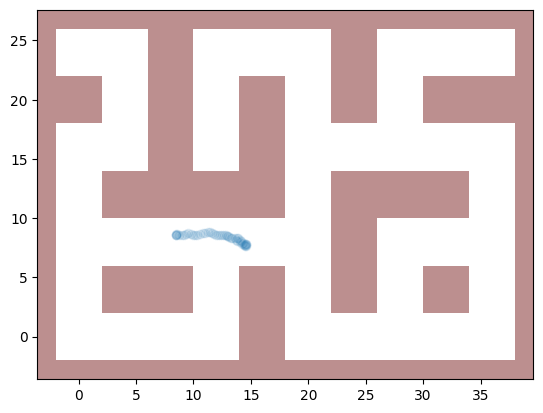

In [46]:
from matplotlib import patches

ax = plt.gca()
torso_x, torso_y = env.env.env._wrapped_env._init_torso_x, env.env.env._wrapped_env._init_torso_y
S =  env.env.env._wrapped_env._maze_size_scaling
for i in range(len(env.env.env._wrapped_env._maze_map)):
    for j in range(len(env.env.env._wrapped_env._maze_map[0])):
        struct = env.env.env._wrapped_env._maze_map[i][j]
        if struct == 1:
            rect = patches.Rectangle((j *S - torso_x - S/ 2,
                                    i * S- torso_y - S/ 2),
                                    S,
                                    S, linewidth=1, facecolor='RosyBrown', alpha=1.0)
            ax.add_patch(rect)
ax.set_xlim(0 - S /2 + 0.6 * S - torso_x, len(env.env.env._wrapped_env._maze_map[0]) * S - torso_x - S/2 - S * 0.6)
ax.set_ylim(0 - S/2 + 0.6 * S - torso_y, len(env.env.env._wrapped_env._maze_map) * S - torso_y - S/2 - S * 0.6)
plt.scatter(xy[:, 0], xy[:, 1], alpha=0.1)

In [16]:
wrapped_env = env.env.env._wrapped_env
torso_x, torso_y = wrapped_env._init_torso_x, wrapped_env._init_torso_y
S = wrapped_env._maze_size_scaling
print((0 - S / 2 + S - torso_x, 0 - S/2 + S - torso_y), (len(wrapped_env._maze_map[0]) * S - torso_x - S/2 - S, len(wrapped_env._maze_map) * S - torso_y - S/2 - S))

def XY(n=20):
    bl, tr = (-2.0, -2.0), (38.0, 26.0)
    X = np.linspace(bl[0] + 0.04 * (tr[0] - bl[0]) , tr[0] - 0.04 * (tr[0] - bl[0]), n)
    Y = np.linspace(bl[1] + 0.04 * (tr[1] - bl[1]) , tr[1] - 0.04 * (tr[1] - bl[1]), n)
    
    X,Y = np.meshgrid(X,Y)
    states = np.array([X.flatten(), Y.flatten()]).T
    return states

(-2.0, -2.0) (38.0, 26.0)


In [23]:
obs = XY()

## AntMaze-Umaze

In [3]:
env = gym.make("antmaze-umaze-v2")
d4rl_ds = d4rl.qlearning_dataset(env)

Target Goal:  (0.7241989442597729, 8.374488737841759)


load datafile: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:02<00:00,  3.36it/s]


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, ListedColormap

xy = d4rl_ds['observations'][np.arange(700, 800)][:, :2]

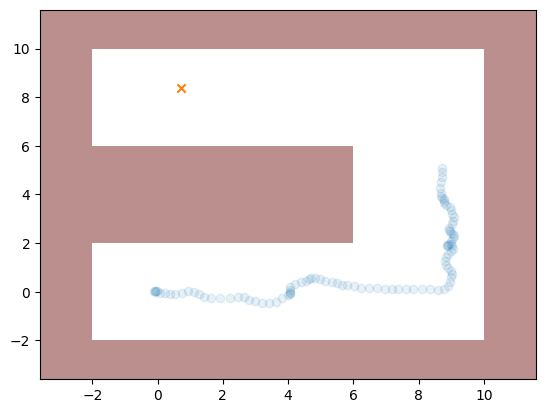

In [9]:
for i in range(len(env.env.env._wrapped_env._maze_map)):
    for j in range(len(env.env.env._wrapped_env._maze_map[0])):
        if env.env.env._wrapped_env._maze_map[i][j] in ['r', 'g']:
            env.env.env._wrapped_env._maze_map[i][j] = 0

from matplotlib import patches

ax = plt.gca()
torso_x, torso_y = env.env.env._wrapped_env._init_torso_x, env.env.env._wrapped_env._init_torso_y
S =  env.env.env._wrapped_env._maze_size_scaling
for i in range(len(env.env.env._wrapped_env._maze_map)):
    for j in range(len(env.env.env._wrapped_env._maze_map[0])):
        struct = env.env.env._wrapped_env._maze_map[i][j]
        if struct == 1:
            rect = patches.Rectangle((j *S - torso_x - S/ 2,
                                    i * S- torso_y - S/ 2),
                                    S,
                                    S, linewidth=1, facecolor='RosyBrown', alpha=1.0)
            ax.add_patch(rect)
ax.set_xlim(0 - S /2 + 0.6 * S - torso_x, len(env.env.env._wrapped_env._maze_map[0]) * S - torso_x - S/2 - S * 0.6)
ax.set_ylim(0 - S/2 + 0.6 * S - torso_y, len(env.env.env._wrapped_env._maze_map) * S - torso_y - S/2 - S * 0.6)
plt.scatter(xy[:, 0], xy[:, 1], alpha=0.1)
plt.scatter(*env.env.env._wrapped_env.target_goal, marker="x")

In [5]:
dones_float = np.zeros_like(d4rl_ds['rewards'])

for i in range(len(dones_float) - 1):
    if np.linalg.norm(d4rl_ds['observations'][i + 1] - d4rl_ds['next_observations'][i]) > 1e-6:
        dones_float[i] = 1
    else:
        dones_float[i] = 0
dones_float[-1] = 1

In [6]:
np.nonzero(dones_float)[0][:300]

array([   699,   1399,   2099,   2799,   3499,   4199,   4899,   5599,
         6299,   6999,   7699,   8399,   9099,   9799,  10499,  11199,
        11899,  12599,  13299,  13999,  14699,  15399,  16099,  16799,
        17499,  18199,  18899,  19599,  20299,  20999,  21699,  22399,
        23099,  23799,  24499,  25199,  25899,  26599,  27299,  27999,
        28699,  29399,  30099,  30799,  31499,  32199,  32899,  33599,
        34299,  34999,  35699,  36399,  37099,  37799,  38499,  39199,
        39899,  40599,  41299,  41999,  42699,  43399,  44099,  44799,
        45499,  46199,  46899,  47599,  48299,  48999,  49699,  50399,
        51099,  51799,  52499,  53199,  53899,  54599,  55299,  55999,
        56699,  57399,  58099,  58799,  59499,  60199,  60899,  61599,
        62299,  62999,  63699,  64399,  65099,  65799,  66499,  67199,
        67899,  68599,  69299,  69999,  70699,  71399,  72099,  72799,
        73499,  74199,  74899,  75599,  76299,  76999,  77699,  78399,
      

In [3]:
env = gym.make("antmaze-umaze-diverse-v2")
d4rl_ds = d4rl.qlearning_dataset(env)

Target Goal:  (1.236760811266488, 8.374969640435834)


load datafile: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:02<00:00,  3.33it/s]


In [7]:
import h5py
from tqdm.auto import tqdm

def get_keys(h5file):
    keys = []

    def visitor(name, item):
        if isinstance(item, h5py.Dataset):
            keys.append(name)

    h5file.visititems(visitor)
    return keys

def get_dataset(h5path):
    data_dict = {}
    with h5py.File(h5path, 'r') as dataset_file:
        for k in tqdm(get_keys(dataset_file), desc="load datafile"):
            try:  # first try loading as an array
                data_dict[k] = dataset_file[k][:]
            except ValueError as e:  # try loading as a scalar
                data_dict[k] = dataset_file[k][()]

    return data_dict
    
random_agent_ds = get_dataset("/home/m_bobrin/AILOT/antmaze-umaze-v2-noiserandomaction.hdf5")

load datafile: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  8.29it/s]


In [78]:
xy = combined['observations'][np.arange(203000, 204000)][:, :2]

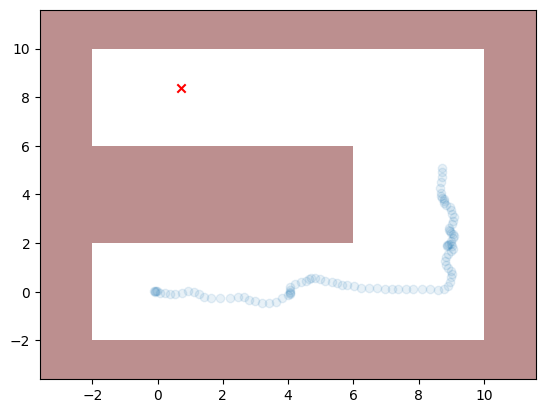

In [12]:
for i in range(len(env.env.env._wrapped_env._maze_map)):
    for j in range(len(env.env.env._wrapped_env._maze_map[0])):
        if env.env.env._wrapped_env._maze_map[i][j] in ['r', 'g']:
            env.env.env._wrapped_env._maze_map[i][j] = 0

from matplotlib import patches

ax = plt.gca()
torso_x, torso_y = env.env.env._wrapped_env._init_torso_x, env.env.env._wrapped_env._init_torso_y
S =  env.env.env._wrapped_env._maze_size_scaling
for i in range(len(env.env.env._wrapped_env._maze_map)):
    for j in range(len(env.env.env._wrapped_env._maze_map[0])):
        struct = env.env.env._wrapped_env._maze_map[i][j]
        if struct == 1:
            rect = patches.Rectangle((j *S - torso_x - S/ 2,
                                    i * S- torso_y - S/ 2),
                                    S,
                                    S, linewidth=1, facecolor='RosyBrown', alpha=1.0)
            ax.add_patch(rect)
ax.set_xlim(0 - S /2 + 0.6 * S - torso_x, len(env.env.env._wrapped_env._maze_map[0]) * S - torso_x - S/2 - S * 0.6)
ax.set_ylim(0 - S/2 + 0.6 * S - torso_y, len(env.env.env._wrapped_env._maze_map) * S - torso_y - S/2 - S * 0.6)
plt.scatter(xy[:, 0], xy[:, 1], alpha=0.1)
plt.scatter(*env.env.env._wrapped_env.target_goal, marker="x", c='red')

In [17]:
def combine_ds(expert_ds, agent_ds):
    expert_timeouts = np.nonzero(dones_float)[0] #np.nonzero(expert_ds['dones_float'])[0] # Timeouts = Not neccesarly achived target goal & received reward
    agent_timeouts = np.nonzero(agent_ds['timeouts'])[0]
    num_expert_trajectories = 500 # each trajectory of size 1k; timeout on each of 700 steps, thus 700 * 500=350k
    num_agent_trajectories = 200
    expert_slice = 700 * num_expert_trajectories
    agent_slice = 1000*num_agent_trajectories

    print(agent_timeouts[:num_agent_trajectories])
    mixed_ds = {
        'observations': np.concatenate((agent_ds['observations'][:agent_slice], expert_ds['observations'][:expert_slice])),
        'next_observations': np.concatenate((agent_ds['next_observations'][:agent_slice], expert_ds['next_observations'][:expert_slice])),
        'rewards': np.concatenate((agent_ds['rewards'][:agent_slice], expert_ds['rewards'][:expert_slice])),
        'actions': np.concatenate((agent_ds['actions'][:agent_slice], expert_ds['actions'][:expert_slice])),
        'terminals': np.concatenate((agent_ds['terminals'][:agent_slice], expert_ds['terminals'][:expert_slice])),
        'dones_float': np.concatenate((agent_timeouts[:num_agent_trajectories], expert_timeouts[:num_expert_trajectories]))
    }
    return mixed_ds
    
combined = combine_ds(d4rl_ds, random_agent_ds)

[  1000   2001   3002   4003   5004   6005   7006   8007   9008  10009
  11010  12011  13012  14013  15014  16015  17016  18017  19018  20019
  21020  22021  23022  24023  25024  26025  27026  28027  29028  30029
  31030  32031  33032  34033  35034  36035  37036  38037  39038  40039
  41040  42041  43042  44043  45044  46045  47046  48047  49048  50049
  51050  52051  53052  54053  55054  56055  57056  58057  59058  60059
  61060  62061  63062  64063  65064  66065  67066  68067  69068  70069
  71070  72071  73072  74073  75074  76075  77076  78077  79078  80079
  81080  82081  83082  84083  85084  86085  87086  88087  89088  90089
  91090  92091  93092  94093  95094  96095  97096  98097  99098 100099
 101100 102101 103102 104103 105104 106105 107106 108107 109108 110109
 111110 112111 113112 114113 115114 116115 117116 118117 119118 120119
 121120 122121 123122 124123 125124 126125 127126 128127 129128 130129
 131130 132131 133132 134133 135134 136135 137136 138137 139138 140139
 14114

In [18]:
combined['dones_float']

array([  1000,   2001,   3002,   4003,   5004,   6005,   7006,   8007,
         9008,  10009,  11010,  12011,  13012,  14013,  15014,  16015,
        17016,  18017,  19018,  20019,  21020,  22021,  23022,  24023,
        25024,  26025,  27026,  28027,  29028,  30029,  31030,  32031,
        33032,  34033,  35034,  36035,  37036,  38037,  39038,  40039,
        41040,  42041,  43042,  44043,  45044,  46045,  47046,  48047,
        49048,  50049,  51050,  52051,  53052,  54053,  55054,  56055,
        57056,  58057,  59058,  60059,  61060,  62061,  63062,  64063,
        65064,  66065,  67066,  68067,  69068,  70069,  71070,  72071,
        73072,  74073,  75074,  76075,  77076,  78077,  79078,  80079,
        81080,  82081,  83082,  84083,  85084,  86085,  87086,  88087,
        89088,  90089,  91090,  92091,  93092,  94093,  95094,  96095,
        97096,  98097,  99098, 100099, 101100, 102101, 103102, 104103,
       105104, 106105, 107106, 108107, 109108, 110109, 111110, 112111,
      